In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Example synthetic dataset for demonstration
class EnergyDataset(Dataset):
    def __init__(self, data, n_input, n_output):
        self.X, self.y = self.prepare_data(data, n_input, n_output)
        
    def prepare_data(self, data, n_input, n_output):
        X, y = [], []
        for i in range(len(data) - n_input - n_output + 1):
            X.append(data[i:i + n_input])
            y.append(data[i + n_input:i + n_input + n_output])
        return np.array(X), np.array(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# CNN-LSTM Model
class CNNLSTM(nn.Module):
    def __init__(self, n_input, n_features, n_output, lstm_units=50):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=(n_input // 2) * 32, hidden_size=lstm_units, batch_first=True)
        self.fc = nn.Linear(lstm_units, n_output)
        
    def forward(self, x):
        # CNN part
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        
        # Flatten the CNN output and prepare for LSTM
        batch_size = x.size(0)
        x = x.view(batch_size, 1, -1)
        
        # LSTM part
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the last LSTM output
        
        # Fully connected output layer
        x = self.fc(x)
        return x

# Generate synthetic data for demonstration
data = np.sin(np.linspace(0, 100, 1000))  
n_input = 30  # Input sequence length
n_output = 7  # Prediction sequence length

# Create dataset and data loader
dataset = EnergyDataset(data, n_input, n_output)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Model parameters
n_features = 1  # Number of features in the input
model = CNNLSTM(n_input, n_features, n_output)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()
    for X, y in data_loader:
        X = X.unsqueeze(1)  # Add channel dimension for Conv1D
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Test the model on new data
model.eval()
test_input = torch.tensor(data[-n_input:], dtype=torch.float32).unsqueeze(0).unsqueeze(1)  # Prepare test input
prediction = model(test_input)
print("Prediction:", prediction.detach().numpy())


Epoch 1/10, Loss: 0.002069421811029315
Epoch 2/10, Loss: 0.00014200589794199914
Epoch 3/10, Loss: 4.402130070957355e-05
Epoch 4/10, Loss: 3.04783352476079e-05
Epoch 5/10, Loss: 1.2219198652019259e-05
Epoch 6/10, Loss: 1.395087929267902e-05
Epoch 7/10, Loss: 7.803056178090628e-06
Epoch 8/10, Loss: 2.815276047840598e-06
Epoch 9/10, Loss: 2.0266188585083e-06
Epoch 10/10, Loss: 1.4869531241856748e-06
Prediction: [[-0.4177265  -0.32612962 -0.2280269  -0.1280372  -0.02984945  0.07159248
   0.17182487]]


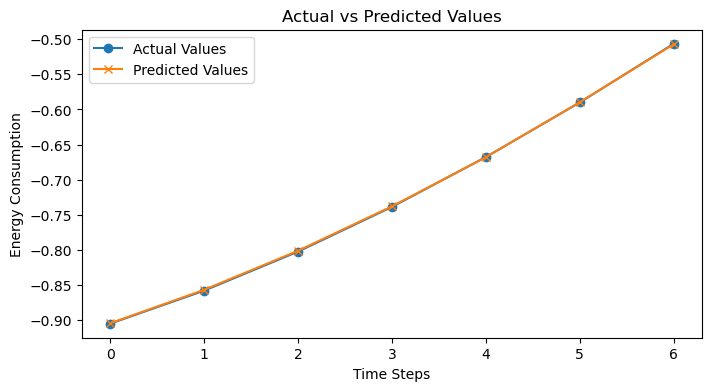

In [10]:
import matplotlib.pyplot as plt

# Modified Training Loop to Store Losses
losses = []  # To store loss at each epoch
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for X, y in data_loader:
        X = X.unsqueeze(1)  # Add channel dimension for Conv1D
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(data_loader)
    losses.append(epoch_loss)
    #print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss}")

# Plot Loss Function
#plt.figure(figsize=(8, 4))
#plt.plot(losses, label="Training Loss")
#plt.xlabel("Epochs")
#plt.ylabel("Loss")
#plt.title("Loss Function over Epochs")
#plt.legend()
#plt.show()

# Test the model on the entire dataset
model.eval()
test_inputs = data[-(n_input + n_output):-n_output]  # Input sequence for testing
actual_values = data[-n_output:]  # Actual values for comparison

test_inputs = torch.tensor(test_inputs, dtype=torch.float32).unsqueeze(0).unsqueeze(1)
predicted_values = model(test_inputs).detach().numpy().flatten()

# Plot Actual vs Predicted
plt.figure(figsize=(8, 4))
plt.plot(range(n_output), actual_values, label="Actual Values", marker='o')
plt.plot(range(n_output), predicted_values, label="Predicted Values", marker='x')
plt.xlabel("Time Steps")
plt.ylabel("Energy Consumption")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()
